# HYSPLIT Modeling V1

This notebook represents an initial attempt to create a workflow for the HYSPLIT program. Currently in use are several functions within a related package called hypy.py. Please make sure to have this python file in the working directory of this notebook alongside a working installation of HYSPLIT and related NARR files.

In [1]:
#Libraries Utilized: 
#USE Lab env!

#Basic py: 
import numpy as np
import pandas as pd
import datetime
import os
import datetime

#Vis
import matplotlib.pyplot as plt

#Geo
import geopandas as gpd
import fiona
from shapely.geometry import Point
import descartes
import contextily as ctx #Basemaps 

#Custom Functions:
from hypy import HYSPLIT_configure, RSEI_merger, hysplit_input_conversion, chem_date_comb,chem_date_comb_2

## Preprocess the TRI Data

In [2]:
#Load the Data
tri_df = pd.read_csv('TRI_Carc_FSRel_9099.csv').drop(columns ='Unnamed: 0')

#First let's load in the features to seperate the particles and gasses
TRI_chem_info = pd.read_csv('TRI_Carc_Half_Lives.csv')

#Keep only those entries with complete information
TRI_chems = TRI_chem_info.dropna(subset = ['CAS'])
TRI_chems = TRI_chems.rename(columns = {'Unnamed: 8':'Phase'})

#Merge that data onto the tri dataframe
tri_df = pd.merge(tri_df,TRI_chem_info,left_on ='CAS_No',right_on = 'CAS',how='left')
tri_df = tri_df.drop(columns = ['CAS','Chems','88-ONE-TIMERELEASE'])

In [3]:
#Seperate into the known differential modeling variants:
fug_par_df = tri_df[(tri_df['51-FUGITIVEAIR']>0) & (tri_df['Particle']==1)]
fug_gas_df = tri_df[(tri_df['51-FUGITIVEAIR']>0) & (tri_df['Gas']==1) ]
stack_par_df = tri_df[(tri_df['52-STACKAIR']>0) & (tri_df['Particle']==1)]
stack_gas_df = tri_df[(tri_df['52-STACKAIR']>0) & (tri_df['Gas']==1) ]

print('Fugitive Particle Releases shape: ' + str(fug_par_df.shape))
print('Total number of unique chemicals: '+str(fug_par_df['CAS_No'].drop_duplicates().shape))
print('Total number of unique polluters: '+str(fug_par_df['FRSID'].drop_duplicates().shape))

print('\nFugitive Gas Releases shape: ' + str(fug_gas_df.shape))
print('Total number of unique chemicals: '+str(fug_gas_df['CAS_No'].drop_duplicates().shape))
print('Total number of unique polluters: '+str(fug_gas_df['FRSID'].drop_duplicates().shape))

print('\nStack Particle Releases shape: ' + str(stack_par_df.shape))
print('Total number of unique chemicals: '+str(stack_par_df['CAS_No'].drop_duplicates().shape))
print('Total number of unique polluters: '+str(stack_par_df['FRSID'].drop_duplicates().shape))

print('\nStack Gas Releases shape: ' + str(stack_gas_df.shape))
print('Total number of unique chemicals: '+str(stack_gas_df['CAS_No'].drop_duplicates().shape))
print('Total number of unique polluters: '+str(stack_gas_df['FRSID'].drop_duplicates().shape))

Fugitive Particle Releases shape: (195, 32)
Total number of unique chemicals: (9,)
Total number of unique polluters: (40,)

Fugitive Gas Releases shape: (526, 32)
Total number of unique chemicals: (20,)
Total number of unique polluters: (75,)

Stack Particle Releases shape: (148, 32)
Total number of unique chemicals: (6,)
Total number of unique polluters: (27,)

Stack Gas Releases shape: (483, 32)
Total number of unique chemicals: (17,)
Total number of unique polluters: (72,)


In [4]:
#Organize the data into daily releases
#fug_par_df = chem_date_comb_2(data = fug_par_df,
#                            freq = "3H",
#                            release_type = 'fugitive'
#                             )

fug_gas_df = chem_date_comb_2(data = fug_gas_df,
                            freq = "3H",
                            release_type = 'fugitive'
                             )

#stack_par_df = chem_date_comb_2(data = stack_par_df,
#                            freq = "3H",
#                            release_type = 'stack'
#                             )

#stack_gas_df = chem_date_comb_2(data = stack_gas_df,
#                            freq = "3H",
#                            release_type = 'stack'
#                             )

Percentage Complete: 0.00
Percentage Complete: 9.51
Percentage Complete: 19.01
Percentage Complete: 28.52
Percentage Complete: 38.02
Percentage Complete: 47.53
Percentage Complete: 57.03
Percentage Complete: 66.54
Percentage Complete: 76.05
Percentage Complete: 85.55
Percentage Complete: 95.06


In [5]:
#Double Check the fill
print('Fugitive Particle Releases shape: ' + str(fug_par_df.shape))
print('Fugitive Gas Releases shape: ' + str(fug_gas_df.shape))
print('Stack Particle Releases shape: ' + str(stack_par_df.shape))
print('Stack Gas Releases shape: ' + str(stack_gas_df.shape))

#Expect: 
#Fugitive Particle Releases shape: (569704, 34)
#Fugitive Gas Releases shape: (1536712, 34)
#Stack Particle Releases shape: (432400, 34)
#Stack Gas Releases shape: (1411088, 34)

Fugitive Particle Releases shape: (195, 32)
Fugitive Gas Releases shape: (1536712, 34)
Stack Particle Releases shape: (148, 32)
Stack Gas Releases shape: (483, 32)


In [6]:
#For now we can just load the saved results from the first year
#Need the Stack Heights as well. 
RSEI_fac_df = pd.read_csv("./RSEI_Facility_Data.csv")

C:\Users\u0890227\Anaconda3\envs\lab\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (19,23,30,31) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [7]:
#We will add the stack information to the fugitive emissions, although we most likely won't use it
#fug_par_df = RSEI_merger(RSEI_fac_df,fug_par_df)
fug_gas_df = RSEI_merger(RSEI_fac_df,fug_gas_df)
#stack_par_df = RSEI_merger(RSEI_fac_df,stack_par_df)
#stack_gas_df = RSEI_merger(RSEI_fac_df,stack_gas_df)

#Convert all inputs to usable metrics: 
#fug_par_prepped_df = hysplit_input_conversion(fug_par_df,0)
fug_gas_prepped_df = hysplit_input_conversion(fug_gas_df,0)
#stack_par_prepped_df = hysplit_input_conversion(stack_par_df,1)
#stack_gas_prepped_df = hysplit_input_conversion(stack_gas_df,1)

In [8]:
#There are some duplicates in the naming process 
#TODO: Figure out a way to handle these
fug_gas_prepped_df[fug_gas_prepped_df.duplicated()][['FACILITYNAME','CAS_No','LATITUDE','LONGITUDE']].drop_duplicates()

,FACILITYNAME,CAS_No,LATITUDE,LONGITUDE
175227,THIOKOL PROPULSION CLEARFIELD OPERATIONS,123911,41.09394,-112.01698
175235,ATK LAUNCH SYSTEMS PROMONTORY,123911,41.66300,-112.43200


In [9]:
#Double check the naming scheme won't save over itself
#with this amount of information in the name, there will be no duplicates 
#except for the two facilities which have doubles coming in...but the overwrite should be ok for now. 

fug_gas_prepped_df[['date','FRSID','CAS_No','HS_loc_input']].drop_duplicates().shape

(1530872, 4)

In [10]:
fug_gas_prepped_df[fug_gas_prepped_df['date']<= '01/01/1990 06:00:00'].shape

(180, 22)

In [12]:
#This will only output the samples for the first day 
samp = fug_gas_prepped_df[fug_gas_prepped_df['date']<= '01/01/1990 06:00:00']

counter = 0 
import timeit
start_time = timeit.default_timer()

for rows in range(samp.shape[0]):
    counter +=1
    release = str(samp.iloc[rows]['Release'])
    fac = str(samp.iloc[rows]['FRSID'])
    chem = str(samp.iloc[rows]['CAS_No'])
    lat_lon_height = str(samp.iloc[rows]['HS_loc_input'])
    date = str(samp.iloc[rows]['date'])
    year = date[2:4]
    month = date[5:7]
    day = date[8:10]
    hour = date[11:13]
    date = year+' '+month + ' '+day+' '+hour
    save_name = fac +"_"+ chem  +"_"+ lat_lon_height.replace(' ', '_') +"_"+year+'_'+month+'_'+day+'_'+hour
    
    HYSPLIT_configure(start_model = date, 
                    num_loc = '1', 
                    start_locs = lat_lon_height, 
                    tot_runtime = '48', 
                    mod_top = '5000.0',
                    input_data_grids = '2',
                    grid_1_dir = "C:\\Users\\u0890227\\Desktop\\TRI_HYSPLIT\\NARR_Weather_Data\\",
                    grid_1_name = 'NARR199001',
                    grid_2_dir = 'C:\\Users\\u0890227\\Desktop\\TRI_HYSPLIT\\NARR_Weather_Data\\',
                    grid_2_name = 'NARR199002',
                    chem_ident = chem,
                    emis_rate = release,
                    emis_hours = '3.0000',
                    samp_interval = '00 03 00',
                    puff_or_part = '0',
                    particle_num = '1000',
                    filename = save_name)
    
    if counter%10==0:
        #break
        print("Total Completed Runs: {0}".format(counter))
elapsed = timeit.default_timer() - start_time    

Script Completed
Script Completed
Script Completed
Script Completed
Script Completed
Script Completed
Script Completed
Script Completed
Script Completed
Script Completed
Total Completed Runs: 10
Script Completed
Script Completed
Script Completed
Script Completed
Script Completed
Script Completed
Script Completed
Script Completed
Script Completed
Script Completed
Total Completed Runs: 20
Script Completed
Script Completed
Script Completed
Script Completed
Script Completed
Script Completed
Script Completed
Script Completed
Script Completed
Script Completed
Total Completed Runs: 30
Script Completed
Script Completed
Script Completed
Script Completed
Script Completed
Script Completed
Script Completed
Script Completed
Script Completed
Script Completed
Total Completed Runs: 40
Script Completed
Script Completed
Script Completed
Script Completed
Script Completed
Script Completed
Script Completed
Script Completed
Script Completed
Script Completed
Total Completed Runs: 50
Script Completed
Script C

In [14]:
print(elapsed)
print('Time of calculation: {0} seconds\n'.format(elapsed/180))
!dir C:\Users\u0890227\Desktop\HYSPLIT\

2756.7937967999997
Time of calculation: 15.31552109333333 seconds



The system cannot find the file specified.


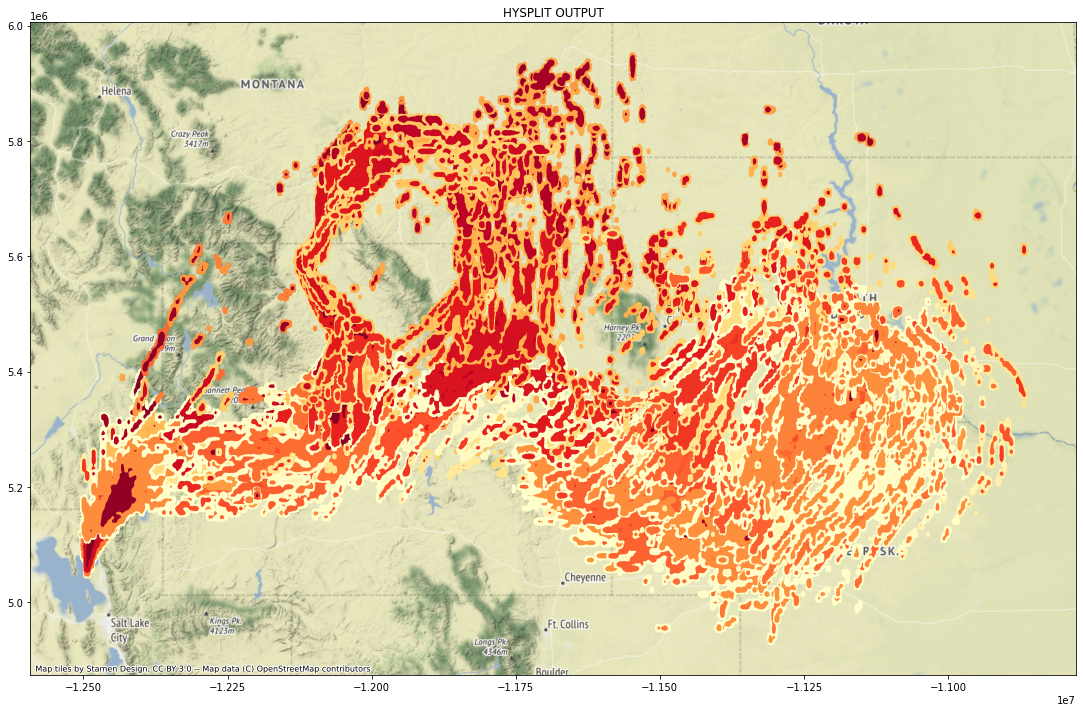

In [28]:
#Plot the sensor locations
f,ax = plt.subplots(1,1,figsize=(24,12))

#plot the location
directory= 'C:\\Users\\u0890227\\Desktop\\TRI_HYSPLIT\\110000758378_108101_41.26_-112.23_0.00_90_01_01_00\\'
for files in os.listdir(directory):
    data = gpd.read_file(directory+files)
    data = data.to_crs({'init': 'epsg:3857'})
    data['CONC'] = data['CONC'].astype(float)
    data.plot(cmap='YlOrRd',ax=ax)

ax.set_title('HYSPLIT OUTPUT')
ctx.add_basemap(ax)

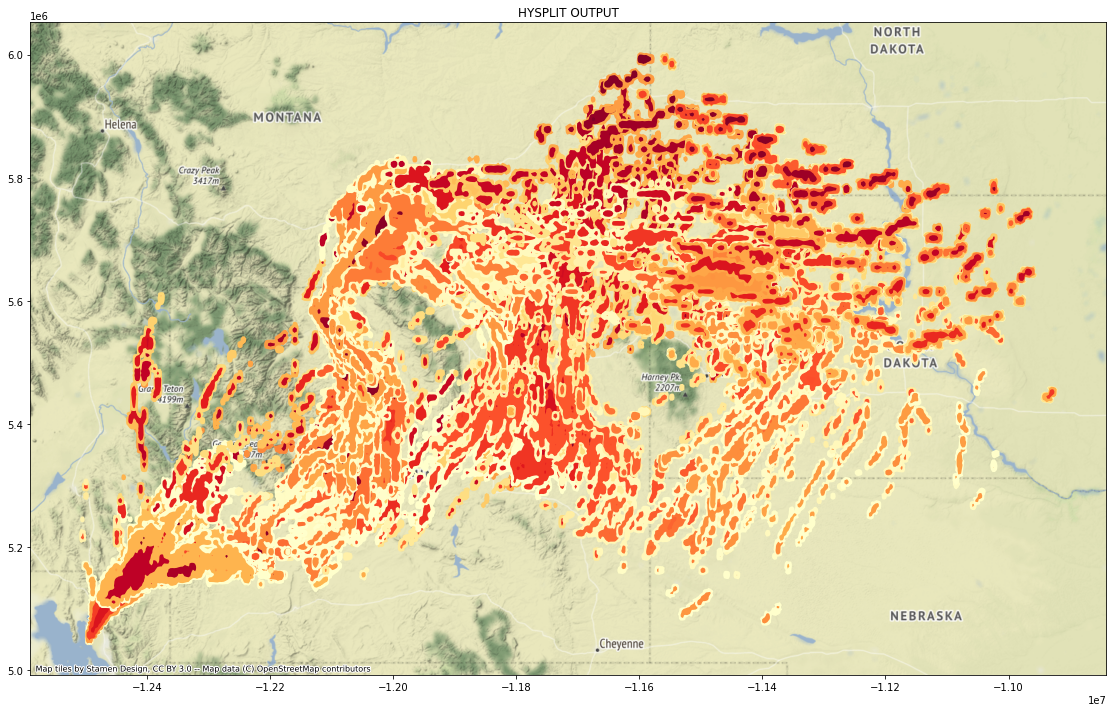

In [36]:
#Plot the sensor locations
f,ax = plt.subplots(1,1,figsize=(24,12))

#plot the location
directory= 'C:\\Users\\u0890227\\Desktop\\TRI_HYSPLIT\\110000758378_108101_41.26_-112.23_0.00_90_01_01_06\\'
for files in os.listdir(directory):
    data = gpd.read_file(directory+files)
    data = data.to_crs({'init': 'epsg:3857'})
    #data['CONC'] = data['CONC'].astype(float)
    data.plot(cmap='YlOrRd',ax=ax)

ax.set_title('HYSPLIT OUTPUT')
ctx.add_basemap(ax)